In [110]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from src.classes.ClassFractionalSin import FractionalSin
from tqdm import tqdm
import numpy as np
import math
from scipy.special import eval_laguerre
from configs.RecursiveVPSDE.Markovian_fSin.recursive_Markovian_fSinWithPosition_T256_H05_tl_5data import get_config
from configs.RecursiveVPSDE.Markovian_fQuadSin.recursive_Markovian_fQuadSinWithPosition_T256_H05_tl_5data import get_config
from configs.RecursiveVPSDE.Markovian_fBiPot.recursive_Markovian_fBiPotWithPosition_T256_H05_tl_5data import get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# From A ridge estimator of the drift from discrete repeated observations of the solutions of a stochastic differential equation (Denis et al 2021)

In [111]:
config = get_config()

In [112]:
def rmse_ignore_nans(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)  # Ignore NaNs in both arrays
    return np.sqrt(np.mean((y_true[mask] - y_pred[mask]) ** 2))

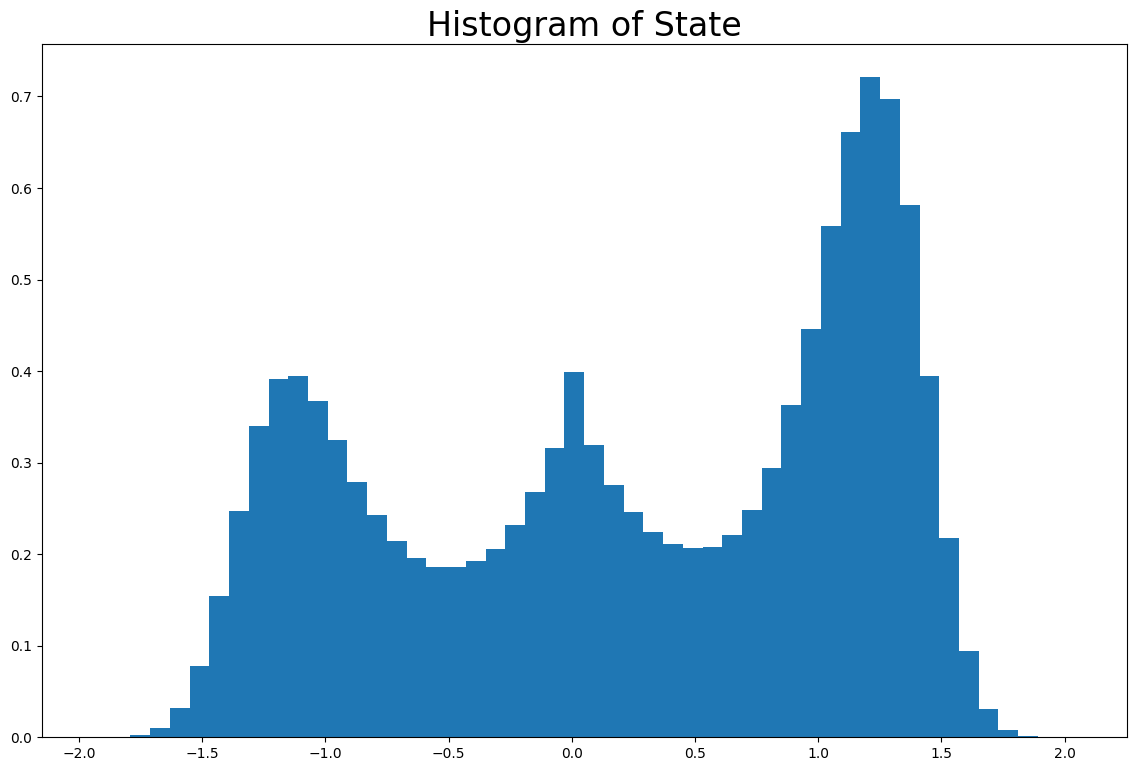

In [113]:
from src.classes.ClassFractionalBiPotential import FractionalBiPotential
from src.classes.ClassFractionalQuadSin import FractionalQuadSin

num_paths = 10152
num_time_steps = int(256)
isUnitInterval = True
diff = config.diffusion
initial_state = 0.
rvs = None
H = config.hurst
deltaT = 1./ (256)
t0 = 0.
t1 = deltaT*num_time_steps
space_scale = 1.
if "QuadSin" in config.data_path:
    fQuadSin = FractionalQuadSin(quad_coeff=config.quad_coeff, sin_coeff= config.sin_coeff, sin_space_scale=config.sin_space_scale, diff=diff, X0=initial_state)
    paths = np.array(
        [fQuadSin.euler_simulation(H=H, N=num_time_steps, deltaT=deltaT, isUnitInterval=isUnitInterval, X0=initial_state, Ms=None, gaussRvs=rvs,
                               t0=t0, t1=t1) for _ in (range(num_paths))]).reshape(
        (num_paths, num_time_steps+1))
elif "fSin" in config.data_path:
    fSin = FractionalSin(mean_rev=config.mean_rev, space_scale=1, diff=diff, X0=initial_state)
    paths = np.array(
        [fSin.euler_simulation(H=H, N=num_time_steps, deltaT=deltaT, isUnitInterval=isUnitInterval, X0=initial_state, Ms=None, gaussRvs=rvs,
                               t0=t0, t1=t1) for _ in (range(num_paths))]).reshape(
        (num_paths, num_time_steps+1))
elif "fBiPot" in config.data_path:
    fBiPot = FractionalBiPotential(const=config.const, quartic_coeff=config.quartic_coeff, quad_coeff = config.quad_coeff, diff=diff, X0=initial_state)
    paths = np.array(
        [fBiPot.euler_simulation(H=H, N=num_time_steps, deltaT=deltaT, isUnitInterval=isUnitInterval, X0=initial_state, Ms=None, gaussRvs=rvs,
                               t0=t0, t1=t1) for _ in (range(num_paths))]).reshape(
        (num_paths, num_time_steps+1))

fig, ax = plt.subplots(figsize=(14,9))
plt.hist(paths.flatten(), bins=50, density=True)
plt.title("Histogram of State", fontsize=24)
plt.show()
plt.close()


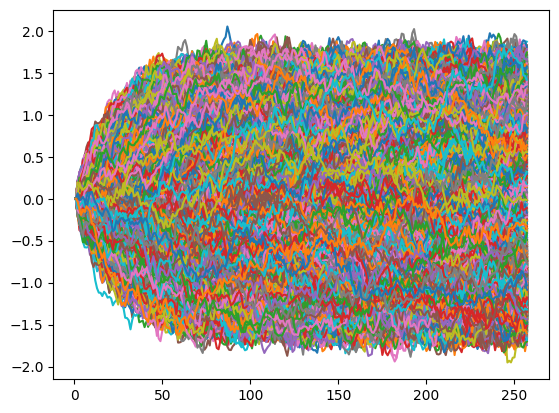

In [114]:
for k in range(num_paths):
    plt.plot(np.arange(1, 258), paths[k,:])
plt.show()

In [49]:
def spline_basis(paths, KN, AN, BN, M):
    assert (paths.shape[0] >= 1 and len(paths.shape)==2)
    assert (AN < BN and KN > 0 and M > 0)
    def construct_ith_knot(i, AN, BN, KN):
        if i < 0:
            return AN
        elif i > KN:
            return BN
        else:
            return AN + i*(BN-AN)/KN
    def bspline(i, l, u, x, KN, M):
        if l == 0 and -M <= i <= KN+M-1:
            return ((u[i] <= x) & (x < u[i+1])).astype(float)
        elif 1 <= l <= M  and -M <= i <= KN+M-l-1:
            num1 = ((x-u[i])/(u[i+l]-u[i]))
            num1[np.isinf(num1)] = 0.
            num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))
            num2[np.isinf(num2)] = 0.
            return num1*bspline(i=i,l=l-1, u=u, x=x, KN=KN, M=M)+num2*bspline(i=i+1, l=l-1, u=u, x=x, KN=KN, M=M)

    knots = {i:construct_ith_knot(i, AN, BN, KN) for i in range(-M, KN+M+1)}
    paths = paths[:,:-1].flatten()
    basis = np.array([bspline(i=i, l=M, u=knots, x=paths, KN=KN,M=M) for i in range(-M, KN)]).T
    assert (basis.shape == (paths.shape[0], KN+M)), f"Basis is shape {basis.shape} but should be {(paths.shape[0], KN+M)}"
    assert np.all(basis >= 0.)
    return basis

import scipy
def find_optimal_estimator_coeffs(B, Z, KN, LN, M):
    # Precompute certain matrices
    BTB = B.T@B
    BTZ = (B.T@Z)
    const = (KN+M)*LN
    if np.all(np.linalg.eigvalsh(BTB)>0.):
        print(f"Matrix BTB is invertible\n")
        a = np.linalg.inv(BTB)@BTZ
        if a.T@a <= const:
            print(f"L2 norm of coefficients automatically satisfies projection constraint\n")
            return a
    I = np.eye(KN+M)
    def obj(l):
        inv = np.linalg.inv(BTB+l*I) @ BTZ
        return np.abs(inv.T@inv - const)
    opt = scipy.optimize.minimize(obj, max(0.,-np.min(np.linalg.eigvalsh(BTB)))+1e-12)
    lhat = np.inf
    while not (opt.success) and not np.allclose(lhat, opt.x):
        lhat = opt.x
        opt = scipy.optimize.minimize(obj, opt.x)
    lhat = opt.x[0]
    a = np.atleast_2d(np.linalg.inv(BTB+lhat*I)@BTZ)
    assert (np.allclose(a.T@a , const))
    return a

def construct_estimator(coeffs, B, LN):
    drift  = B@coeffs
    drift[np.abs(drift) > np.sqrt(LN)] = np.sqrt(LN)*np.sign(drift[np.abs(drift) > np.sqrt(LN)])
    return drift


In [82]:
AN = -1.7
BN = -AN
M = 4
LN = np.log(num_paths)
KNs = {2**p: np.inf for p in [0, 1, 3, 4, 5]}
for KN in list(KNs.keys()):
    break
    B = spline_basis(paths=paths[:num_paths,:], KN=KN, AN=AN, BN=BN, M=M)
    Z = np.power(deltaT,-1)*np.diff(paths[:num_paths,:], axis=1).reshape((paths[:num_paths,:].shape[0]*(paths.shape[1]-1),1))
    assert (B.shape[0] == Z.shape[0] and len(B.shape)==len(Z.shape) == 2)
    coeffs = find_optimal_estimator_coeffs(B=B, Z=Z, KN=KN, LN=LN, M=M)
    drift = construct_estimator(coeffs=coeffs, B=B, LN=LN).flatten()
    KNs[KN] = np.mean(np.power(drift-Z.flatten(),2)) + 0.1*np.power(np.log(num_paths),2)*(KN+M)/num_paths
#KN = list(dict(sorted(KNs.items(), key= lambda item: item[1])).keys())[0]

In [83]:
KN = 10

In [84]:
B = spline_basis(paths=paths[:num_paths,:], KN=KN, AN=AN, BN=BN, M=M)
Z = np.power(deltaT,-1)*np.diff(paths[:num_paths,:], axis=1).reshape((paths[:num_paths,:].shape[0]*(paths.shape[1]-1),1))
assert (B.shape[0] == Z.shape[0] and len(B.shape)==len(Z.shape) == 2)
coeffs = find_optimal_estimator_coeffs(B=B, Z=Z, KN=KN, LN=LN, M=M)

/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_25251/2568163073.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_25251/2568163073.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))


Matrix BTB is invertible



In [85]:
"""is_true_drift = mean_rev*np.sin(space_scale*paths[:num_paths,:-1].flatten())
is_true_drift[paths[:num_paths,:-1].flatten() < AN] = np.nan
is_true_drift[paths[:num_paths,:-1].flatten() > BN] = np.nan
plt.scatter(paths[:num_paths,:-1].flatten(), is_true_drift, s=10,label="True Drift", color="blue")
is_drift = construct_estimator(coeffs=coeffs, B=B, LN=LN).flatten()
is_drift[paths[:num_paths,:-1].flatten() < AN] = np.nan
is_drift[paths[:num_paths,:-1].flatten() > BN] = np.nan
plt.scatter(paths[:num_paths,:-1].flatten(), is_drift, s=10,label="Estimated Drift", color="orange")
plt.xlim(AN-0.5, BN+0.5)
plt.legend()
print(rmse_ignore_nans(is_drift, is_true_drift))"""

'is_true_drift = mean_rev*np.sin(space_scale*paths[:num_paths,:-1].flatten())\nis_true_drift[paths[:num_paths,:-1].flatten() < AN] = np.nan\nis_true_drift[paths[:num_paths,:-1].flatten() > BN] = np.nan\nplt.scatter(paths[:num_paths,:-1].flatten(), is_true_drift, s=10,label="True Drift", color="blue")\nis_drift = construct_estimator(coeffs=coeffs, B=B, LN=LN).flatten()\nis_drift[paths[:num_paths,:-1].flatten() < AN] = np.nan\nis_drift[paths[:num_paths,:-1].flatten() > BN] = np.nan\nplt.scatter(paths[:num_paths,:-1].flatten(), is_drift, s=10,label="Estimated Drift", color="orange")\nplt.xlim(AN-0.5, BN+0.5)\nplt.legend()\nprint(rmse_ignore_nans(is_drift, is_true_drift))'

In [86]:
"""oos_paths = np.array(
    [fSin.euler_simulation(H=H, N=num_time_steps, deltaT=deltaT, isUnitInterval=isUnitInterval, X0=0, Ms=None, gaussRvs=rvs,
                           t0=t0, t1=t1) for _ in (range(num_paths))]).reshape(
    (num_paths, num_time_steps+1))
oos_true_drift = mean_rev*np.sin(space_scale*oos_paths[:num_paths,:-1].flatten())
oos_true_drift[oos_paths[:num_paths,:-1].flatten() < AN] = np.nan
oos_true_drift[oos_paths[:num_paths,:-1].flatten() > BN] = np.nan
plt.scatter(oos_paths[:num_paths,:-1].flatten(), oos_true_drift, s=10,label="True Drift", color="blue")
oos_B = spline_basis(paths=oos_paths[:num_paths,:], KN=KN, AN=AN, BN=BN, M=M)
oos_drift = construct_estimator(coeffs=coeffs, B=oos_B, LN=LN).flatten()
oos_drift[oos_paths[:num_paths,:-1].flatten() < AN] = np.nan
oos_drift[oos_paths[:num_paths,:-1].flatten() > BN] = np.nan
plt.scatter(oos_paths[:num_paths,:-1].flatten(), oos_drift, s=10,label="Estimated Drift", color="orange")
plt.xlim(AN-0.5, BN+0.5)
plt.legend()
print(rmse_ignore_nans(oos_true_drift, oos_drift))"""

'oos_paths = np.array(\n    [fSin.euler_simulation(H=H, N=num_time_steps, deltaT=deltaT, isUnitInterval=isUnitInterval, X0=0, Ms=None, gaussRvs=rvs,\n                           t0=t0, t1=t1) for _ in (range(num_paths))]).reshape(\n    (num_paths, num_time_steps+1))\noos_true_drift = mean_rev*np.sin(space_scale*oos_paths[:num_paths,:-1].flatten())\noos_true_drift[oos_paths[:num_paths,:-1].flatten() < AN] = np.nan\noos_true_drift[oos_paths[:num_paths,:-1].flatten() > BN] = np.nan\nplt.scatter(oos_paths[:num_paths,:-1].flatten(), oos_true_drift, s=10,label="True Drift", color="blue")\noos_B = spline_basis(paths=oos_paths[:num_paths,:], KN=KN, AN=AN, BN=BN, M=M)\noos_drift = construct_estimator(coeffs=coeffs, B=oos_B, LN=LN).flatten()\noos_drift[oos_paths[:num_paths,:-1].flatten() < AN] = np.nan\noos_drift[oos_paths[:num_paths,:-1].flatten() > BN] = np.nan\nplt.scatter(oos_paths[:num_paths,:-1].flatten(), oos_drift, s=10,label="Estimated Drift", color="orange")\nplt.xlim(AN-0.5, BN+0.5)\np

1.9749537536229231


/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_25251/2568163073.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_25251/2568163073.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))


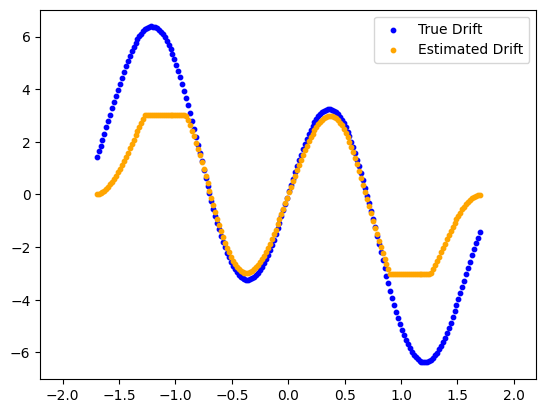

In [87]:
ppaths = np.linspace(AN-0.5, BN+0.5, 256).reshape(1, -1)
if "QuadSin" in config.data_path:
    unif_true_drift = 2.*config.quad_coeff * ppaths[:,:-1].flatten() + config.sin_coeff * config.sin_space_scale*np.sin(config.sin_space_scale*ppaths[:,:-1].flatten())
elif "fSin" in config.data_path:
    unif_true_drift = config.mean_rev*np.sin(space_scale*ppaths[:,:-1].flatten())
unif_true_drift[ppaths[:,:-1].flatten() < AN] = np.nan
unif_true_drift[ppaths[:,:-1].flatten() > BN] = np.nan
plt.scatter(ppaths[:,:-1].flatten(), unif_true_drift, label="True Drift", s=10, color="blue")
unif_B = spline_basis(paths=ppaths[:,:], KN=KN, AN=AN, BN=BN, M=M)
unif_drift = construct_estimator(coeffs=coeffs, B=unif_B, LN=LN).flatten()
unif_drift[ppaths[:,:-1].flatten() < AN] = np.nan
unif_drift[ppaths[:,:-1].flatten() > BN] = np.nan
plt.scatter(ppaths[:,:-1].flatten(), unif_drift, label="Estimated Drift", s=10,color="orange")
plt.xlim(AN-0.5, BN+0.5)
plt.legend()
print(rmse_ignore_nans(unif_true_drift, unif_drift))